In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
import math 

Task 1, Reference : [7] [4]

In [28]:
def normalise_data(x,mean,std,dimensions):

    #normalising the data using a transformation 

    #define the normalisation matrix for two or three dimensions, as needed
    if dimensions == 2:
        Norm_Matrix = [[std,0,mean[0]],[0,std,mean[1]],[0,0,1]]
    else:
        Norm_Matrix = [[std,0,0,mean[0]],[0,std,0,mean[1]],[0,0,std,mean[2]],[0,0,0,1]]
    
    
    Norm_Matrix = np.asarray(Norm_Matrix)
    Norm_Matrix_Inverse = np.linalg.inv(Norm_Matrix)

    #add a row of ones to the data for dot operation 
    form_for_normalisation = np.concatenate((x.T,np.ones((1,x.shape[0]))))

    #multiply the data with normalisation matrix 
    normalised_x = np.dot(Norm_Matrix_Inverse,form_for_normalisation)

    #delete the extra row added for dot operation 
    normalised_x = normalised_x[0:dimensions,:].T

    return Norm_Matrix_Inverse,normalised_x
    
def calibrate(im, XYZ, uv):

    '''
    %% TASK 1: CALIBRATE
    %
    % Function to perform camera calibration
    %
    % Usage:   calibrate(image, XYZ, uv)
    %          return C
    %   Where:   image - is the image of the calibration target.
    %            XYZ - is a N x 3 array of  XYZ coordinates
    %                  of the calibration target points. 
    %            uv  - is a N x 2 array of the image coordinates
    %                  of the calibration target points.
    %            K   - is the 3 x 4 camera calibration matrix.
    %  The variable N should be an integer greater than or equal to 6.
    %
    %  This function plots the uv coordinates onto the image of the calibration
    %  target. 
    %
    %  It also projects the XYZ coordinates back into image coordinates using
    %  the calibration matrix and plots these points too as 
    %  a visual check on the accuracy of the calibration process.
    %
    %  Lines from the origin to the vanishing points in the X, Y and Z
    %  directions are overlaid on the image. 
    %
    %  The mean squared error between the positions of the uv coordinates 
    %  and the projected XYZ coordinates is also reported.
    %
    %  The function should also report the error in satisfying the 
    %  camera calibration matrix constraints.
    % 
    % Kirat Alreja, 23/05/2022
    '''


    img_dim = im.shape[2]
    world = np.asarray(XYZ)
    dim_world = world.shape[1]
    image = np.asarray(uv)
    dim_image = image.shape[1]
    
    #normalise both world & image points 
    world_norm_matrix, world_normalised = normalise_data(world,np.mean(world,0),np.std(world),dim_world)
    image_norm_matrix, image_normalised = normalise_data(image,np.mean(image,0),np.std(image),dim_image)
    
    #calculate the A matrix equation for calibration 
    A = []
    for i in range(world.shape[0]):
        x, y, z = world_normalised[i, 0], world_normalised[i, 1], world_normalised[i, 2]
        u, v = image_normalised[i, 0], image_normalised[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )
    A = np.asarray(A)
    
    #perform SVD on A 
    U, S, V = np.linalg.svd(A)
    
    #solution is in the last column of V, and normalise it 
    C = V[-1, :] / V[-1, -1]

    #reshape it to 3x4 matrix 
    C = C.reshape((3,img_dim+1))

    return C

def get_points_and_error(XYZ,uv):
    
    #perform similar operations to "calibrate", but for calculating 
    #the projected points & DLT error 
    world = np.asarray(XYZ)
    dim_world = world.shape[1]
    image = np.asarray(uv)
    dim_image = image.shape[1]

    world_norm_matrix, world_normalised = normalise_data(world,np.mean(world,0),np.std(world),dim_world)
    image_norm_matrix, image_normalised = normalise_data(image,np.mean(image,0),np.std(image),dim_image)

    A = []
    for i in range(world.shape[0]):
        x, y, z = world_normalised[i, 0], world_normalised[i, 1], world_normalised[i, 2]
        u, v = image_normalised[i, 0], image_normalised[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )
    A = np.asarray(A)

    U, S, V = np.linalg.svd(A)

    C = V[-1, :] / V[-1, -1]
  
    
    #H matrix is used for calculating the value of projected points 
    H = C.reshape(3, 4)

    #Peform denormaliation 
    H = np.dot(np.dot( np.linalg.pinv(image_norm_matrix), H ), world_norm_matrix)

    #Normalise with last column & row 
    H = H / H[-1, -1]
    
    #Calculate the projected points, with dot product of H & world coordinates appended with 1
    projected_points = np.dot( H, np.concatenate( (world.T, np.ones((1, world.shape[0]))) ) ) 

    #Normalise the projected points 
    projected_points = projected_points / projected_points[2, :] 

    #mean distance between true & projected points 
    error = np.sqrt( np.mean(np.sum( (projected_points[0:2, :].T - uv)**2, 1)) ) 
    
    #delete the appened ones column 
    projected_points = projected_points[0:2]

    return error,projected_points

def annotate_image(image,points):
    #annotate the image with given points 
    #for better visualisation 
    x = points[0,:]
    y = points[1,:]

    for i in range(6):
        cv.circle(image,(int(x[i]),int(y[i])),2,(255,0,0),-1)

    return image

def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q

def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
    print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t
    

In [6]:
#User input for selecting the points on 'stereo2012a' image
matplotlib.use('TkAgg')
image = cv.imread('stereo2012a.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
uv = plt.ginput(6)
uv = np.round_(uv)
print(uv)
plt.close('all')

[[331. 369.]
 [376. 380.]
 [356. 297.]
 [400. 309.]
 [283. 311.]
 [247. 336.]]


In [36]:
#selected world & image points 
image = cv.imread('stereo2012a.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
XYZ = [[7,0,7], [14,0,7], [7,7,0], [14,7,0], [0,7,7], [0,7,14]]
uv = [[331, 369], [376, 380], [356, 297], [400, 309], [283, 311], [247, 336]]

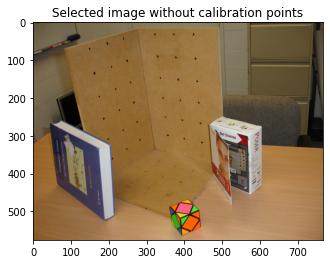

In [44]:
#visualise selected image without points
plt.imshow(image)
plt.title('Selected image without calibration points');
plt.savefig('foo.png')

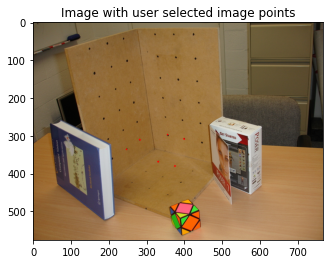

In [47]:
#annotate the original image with selected user image points 
numpy_points = np.asarray(uv)
for i in range(6):
        cv.circle(image,(int(uv[i][0]),int(uv[i][1])),2,(255,0,0),-1)
plt.imshow(image)
plt.title('Image with user selected image points');
plt.savefig('foo1.png')

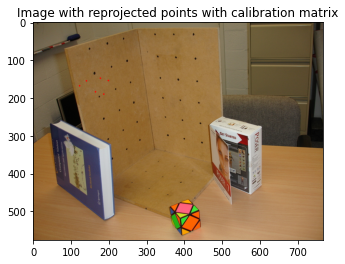

In [66]:
Calibration_Matrix = calibrate(image,XYZ,uv)
Error, Projected_Points = get_points_and_error(XYZ,uv)

Projected_Points_To_Image = annotate_image(image,Projected_Points)
plt.imshow(Projected_Points_To_Image)
plt.title('Image with reprojected points with calibration matrix');
plt.savefig('foo3.png')

In [46]:
Calibration_Matrix

array([[ 0.70762418, -0.05287326, -0.46887587,  0.03752043],
       [ 0.17781128, -0.74564872,  0.40374439, -0.00829428],
       [-0.00708621, -0.01915903, -0.04322884,  1.        ]])

In [67]:
#extracting K,R,T from the Calibration Matrix 
K,R,t = vgg_KR_from_P(Calibration_Matrix)

3 | [[ 0.70762418 -0.05287326 -0.46887587]
 [ 0.17781128 -0.74564872  0.40374439]
 [-0.00708621 -0.01915903 -0.04322884]]


In [89]:
print(K,'K Matrix')

[[16.30219637  0.18086396  7.11613012]
 [ 0.         18.01669172 -1.93677821]
 [ 0.          0.          1.        ]] K Matrix


In [90]:
print(R,'R Matrix')

[[ 0.97043795  0.11716372 -0.21100439]
 [ 0.19048429 -0.90868113  0.37150281]
 [-0.14820905 -0.40071345 -0.9041365 ]] R Matrix


In [93]:
print(t,'t Matrix')

[11.51059845 11.48220516 16.15693432] t Matrix


In [8]:
#Reprojection Error 
print("Reprojection Error",Error)

Reprojection Error 0.6056907235208031


Resized Image 

In [ ]:
#User input for selecting the points on resized image
image = cv.imread('stereo2012a.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
H, W, _ = image.shape
dim = (int(W/2), int(H/2))
matplotlib.use('TkAgg')
plt.imshow(image)
uv = plt.ginput(6)
uv = np.round_(uv)
print(uv)
plt.close('all')

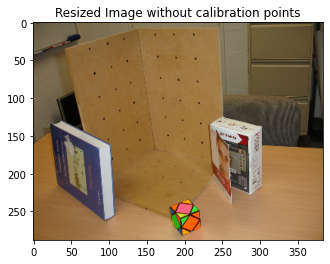

In [57]:
image = cv.imread('stereo2012a.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
H, W, _ = image.shape
dim = (int(W/2), int(H/2))
image_r_original = cv.resize(image, dim, interpolation = cv.INTER_NEAREST)
plt.title('Resized Image without calibration points');
plt.imshow(image_r_original);
plt.savefig('foo4.png')

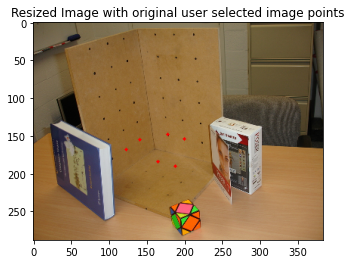

In [58]:
#Resizing the image to half width & height 
image = cv.imread('stereo2012a.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
H, W, _ = image.shape
dim = (int(W/2), int(H/2))
image_r_original = cv.resize(image, dim, interpolation = cv.INTER_NEAREST)
image_r_projected = cv.resize(image, dim, interpolation = cv.INTER_NEAREST)

XYZ = [[7,0,7], [14,0,7], [7,7,0], [14,7,0], [0,7,7], [0,7,14]]
#coordinates adjusted to half of the original image for calculations 
uv = [[165.5,184.5],[188,190],[178,148.5],[200,154.5],[141.5,155.5],[123.5,168]]
uv = (np.asarray(uv))

for i in range(6):
        cv.circle(image_r_original,(int(uv[i][0]),int(uv[i][1])),2,(255,0,0),-1)
plt.imshow(image_r_original)
plt.title('Resized Image with original user selected image points');
plt.savefig('foo5.png')

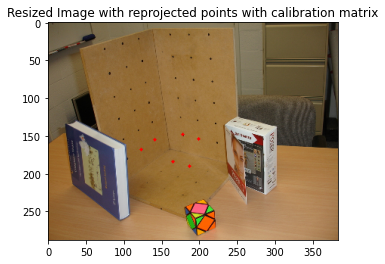

In [59]:
#Displaying the projected points with calibration matrix on resized image 
Calibration_Matrix = calibrate(image_r_projected,XYZ,uv)
Error, Projected_Points = get_points_and_error(XYZ,uv)

Projected_Points_To_Image = annotate_image(image_r_projected,Projected_Points)
plt.imshow(Projected_Points_To_Image)
plt.title('Resized Image with reprojected points with calibration matrix');
plt.savefig('foo5.png')

In [94]:
#Extracting calibration matrix
K,R,t = vgg_KR_from_P(Calibration_Matrix)

3 | [[ 0.70762418 -0.05287326 -0.46887587]
 [ 0.17781128 -0.74564872  0.40374439]
 [-0.00708621 -0.01915903 -0.04322884]]


In [95]:
print(K,'K Matrix')

[[16.30219637  0.18086396  7.11613012]
 [ 0.         18.01669172 -1.93677821]
 [ 0.          0.          1.        ]] K Matrix


In [96]:
print(R,'R Matrix')

[[ 0.97043795  0.11716372 -0.21100439]
 [ 0.19048429 -0.90868113  0.37150281]
 [-0.14820905 -0.40071345 -0.9041365 ]] R Matrix


In [97]:
print(t,'t Matrix')

[11.51059845 11.48220516 16.15693432] t Matrix


In [12]:
#Reprojection error 
print("Reprojection Error",Error)

Reprojection Error 0.302845361760393


Task 2 , Reference :[1] [2] [3] [9]

In [7]:
#Taking inputs on points for 'Right' image 
matplotlib.use('TkAgg')
right = cv.imread('Right.jpg')
right = cv.cvtColor(right, cv.COLOR_BGR2RGB)
plt.imshow(right)
right_uv = plt.ginput(6)
right_uv = np.round_(right_uv)
print(right_uv)
plt.close('all')

In [3]:
#Taking inputs on points for 'Left' image
matplotlib.use('TkAgg')
left = cv.imread('Left.jpg')
left = cv.cvtColor(left, cv.COLOR_BGR2RGB)
plt.imshow(left)
left_uv = plt.ginput(6)
left_uv = np.round_(left_uv)
print(left_uv)
plt.close('all')

In [8]:
#Selected six corresponding points for both images  
right_uv = [[207,183],[246,182],[282,183],[281,203],[245,203],[208,202]]
right_uv = np.asarray(right_uv)
left_uv = [[176,151],[203,155],[232,159],[231,183],[201,178],[175,174]]
left_uv = np.asarray(left_uv)

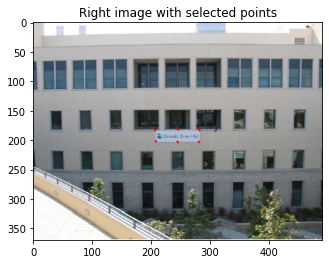

In [98]:
#Annotate and display 'Right' image with selected points 
for i in range(6):
        cv.circle(right,(int(right_uv[i][0]),int(right_uv[i][1])),2,(255,0,0),-1)
plt.imshow(right);
plt.title('Right image with selected points');
plt.savefig('right_image.png')

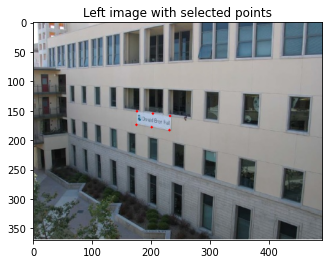

In [99]:
#Annotate and display 'Left' image with selected points 
for i in range(6):
        cv.circle(left,(int(left_uv[i][0]),int(left_uv[i][1])),2,(255,0,0),-1)
plt.imshow(left);
plt.title('Left image with selected points');
plt.savefig('left_image.png')

In [101]:
def homography(u2Trans,v2Trans,uBase,vBase):

    '''
    %% TASK 2: 
    % Computes the homography H applying the Direct Linear Transformation 
    % The transformation is such that 
    % p = np.matmul(H, p.T), i.e.,
    % (uBase, vBase, 1).T = np.matmul(H, (u2Trans , v2Trans, 1).T)
    % Note: we assume (a, b, c) => np.concatenate((a, b, c), axis), be careful when 
    % deal the value of axis 
    %
    % INPUTS: 
    % u2Trans, v2Trans - vectors with coordinates u and v of the transformed image point (p') 
    % uBase, vBase - vectors with coordinates u and v of the original base image point p  
    % 
    % OUTPUT 
    % H - a 3x3 Homography matrix  
    % 
    % Kirat Alreja, 23rd May 2022
    '''

    #concatenate x & y points into single image 
    right_uv = np.concatenate((u2Trans,v2Trans),axis=1)
    left_uv = np.concatenate((uBase,vBase),axis=1)
    
    #use homography equations to form the matrix for SVD operation 
    A_0 = np.column_stack((left_uv,np.ones(left_uv.shape[0]),np.zeros((left_uv.shape[0],3)),-left_uv[:,0]*right_uv[:,0],-left_uv[:,1]*right_uv[:,0],-right_uv[:,0]))
    A_1 = np.column_stack((np.zeros((left_uv.shape[0],3)),left_uv,np.ones(left_uv.shape[0]),-left_uv[:,0]*right_uv[:,1],-left_uv[:,1]*right_uv[:,1],-right_uv[:,1]))
    A = np.vstack((A_0,A_1))

    #calculating the SVD operation, and extracting solution from the last column of V matrix 
    H = np.linalg.svd(A)[-1][-1]
    #normalise the matrix with last column
    H = H/H[-1]

    #reshape result to 3x3
    H = H.reshape(3,3)

    return H

In [102]:
H = homography(right_uv[:,0].reshape(-1,1),right_uv[:,1].reshape(-1,1),left_uv[:,0].reshape(-1,1),left_uv[:,1].reshape(-1,1))
print(H)

[[ 1.99985469e+01  6.15298599e+00 -2.56404595e+03]
 [ 3.96069291e+00  1.30528261e+01 -1.00935137e+03]
 [ 2.68917925e-02  2.25193304e-02  1.00000000e+00]]


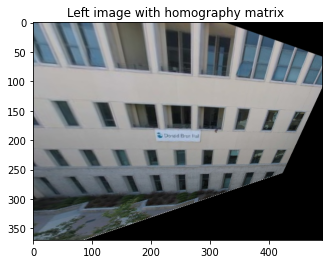

In [103]:
#display the warped image with homography matrix 
warped = cv.imread('Left.jpg')
warped = cv.cvtColor(warped, cv.COLOR_BGR2RGB)
height, width, _ = warped.shape
warped = cv.warpPerspective(warped, H, (width, height))
plt.imshow(warped);
plt.title('Left image with homography matrix ');
plt.savefig('homography.png')

In [ ]:
#select the corresponding points on the warped image with homography matrix 
warped_uv = plt.ginput(6)
warped_uv = np.round_(warped_uv)
print(warped_uv)
plt.close('all')

In [27]:
#selected warped image points
warped_uv = [[206,182],[247,182],[285,184],[283,202],[248,202],[210,203]]
warped_uv = np.asarray(warped_uv)

#calculate the distance between true points & warped points 
distance = np.zeros(warped_uv.shape[0])

for i in range(warped_uv.shape[0]):
    cur_dist = math.sqrt((right_uv[i][0] - warped_uv[i][0])**2 + (right_uv[i][1] - warped_uv[i][1])**2)
    distance[i] = cur_dist

distance = np.round(distance)

print('distance between points',distance)

#calculate the mean distance of points
print('mean distance ',np.mean(distance))

distance between points [1. 1. 3. 2. 3. 2.]
mean distance  2.0


References
[1] : https://math.stackexchange.com/questions/1801564/solving-for-homography-svd-vs-linear-least-squares-matlab

[2] : https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html

[3] :
https://cseweb.ucsd.edu/classes/wi07/cse252a/homography_estimation/homography_estimation.pdf

[4]: http://saurabhg.web.illinois.edu/teaching/ece549/sp2020/slides/lec14_calibration.pdf

[5] : https://answers.opencv.org/question/118918/does-the-resolution-of-an-image-affect-the-distortion-co-efficients/

[6] : https://ksimek.github.io/2012/08/14/decompose/

[7] : https://www.mail-archive.com/floatcanvas@mithis.com/msg00513.html

[8] : https://www.cs.cmu.edu/~16385/s17/Slides/10.2_2D_Alignment__DLT.pdf

[9] : https://github.com/w181496/homography/blob/master/homography.py

[10] :http://saurabhg.web.illinois.edu/teaching/ece549/sp2020/slides/lec14_calibration.pdf